In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as torch_data
import torch.nn.functional as F
import random
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.utils.data as torch_data
from nilearn import plotting
import nibabel as nib
import nilearn
import os
from sklearn.model_selection import train_test_split, StratifiedKFold
import time

In [2]:
import grad_cam
from meanpertrub_old import MeanPertrub

random.seed(82)
torch.manual_seed(82)
torch.cuda.manual_seed(82)
np.random.seed(82)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
CHECKPOINTS_DIR = '/home/checkpoints/'
isTrain = True

In [3]:
X = np.load('/data/adni/tensors_cut.npz')
y = np.load('/data/adni/labels.npy')

In [4]:
X = X.f.arr_0

In [5]:
X[0].shape

(1, 180, 180, 180)

In [6]:
print(X.shape, y.shape)

(517, 1, 180, 180, 180) (517,)


In [7]:
class MriData(torch.utils.data.Dataset):
    def __init__(self, X, y, transform):
        super(MriData, self).__init__()
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y).long()
        self.transform = transform
    
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
#         sample = {'img': self.X[idx], 'landmarks': self.y[idx]}
#         if self.transform:
#                    sample = self.transform(sample)
        return self.X[idx], self.y[idx]

In [8]:
class MriNetGrad(nn.Module):
    def __init__(self, c):
        super(MriNetGrad, self).__init__()
        self.features = nn.Sequential( 
                nn.Conv3d(1, c, kernel_size=3),
                nn.BatchNorm3d(c),
                nn.ReLU(),
                nn.MaxPool3d(kernel_size=3),
                
                nn.Conv3d(c, 2*c, kernel_size=3),
                nn.BatchNorm3d(2*c),
                nn.ReLU(),
                nn.MaxPool3d(kernel_size=3),
                
                nn.Conv3d(2*c, 4*c, kernel_size=3, stride=1, dilation=1, padding=0),
                nn.BatchNorm3d(4*c),
                nn.ReLU()
        )
        self.classifier = nn.Sequential(
            nn.MaxPool3d(kernel_size=3),
            nn.Flatten(),
            nn.Linear(in_features=4*c*5*5*5, out_features=2),
        )
        self.gradients = None
        
  
    def activations_hook(self, grad):
        self.gradients = grad

    def forward(self, x):
        x = self.features(x)
        h = x.register_hook(self.activations_hook)
        x = self.classifier(x)
        return x
    
    def get_activations_gradient(self):
        return self.gradients
    
    def get_activations(self, x):
        return self.features(x)
    
torch.manual_seed(1)
np.random.seed(1)

c = 32
model = MriNetGrad(c)

In [9]:
# ## Hidden layers 1, 2 and 3
# hidden = lambda c_in, c_out: nn.Sequential(
#     nn.Conv3d(c_in, c_out, (3,3,3)), # Convolutional layer
#     nn.BatchNorm3d(c_out), # Batch Normalization layer
#     nn.ReLU(), # Activational layer
#     nn.MaxPool3d(3) # Pooling layer
# )

# class MriNet(nn.Module):
#     def __init__(self, c):
#         super(MriNet, self).__init__()
#         self.hidden1 = hidden(1, c)
#         self.hidden2 = hidden(c, 2*c)
#         self.hidden3 = hidden(2*c, 4*c)
#         self.hidden4 = hidden(4*c, 4*c)
#         self.linear = nn.Linear(128, 2)#16000
# #         self.linear = nn.Linear(128*5*5*5, 2)#16000
#         self.flatten = nn.Flatten()

#     def forward(self, x):
# #         print(x.shape)
#         x = self.hidden1(x)
#         x = self.hidden2(x)
#         x = self.hidden3(x)
#         x = self.hidden4(x)
# #         print(x.shape)
#         x = self.flatten(x)
#         x = self.linear(x)
        
#         x = F.log_softmax(x, dim=1)
#         return x

# torch.manual_seed(1)
# np.random.seed(1)

# c = 32
# model = MriNet(c)


In [9]:
!nvidia-smi

Thu Apr  1 23:43:48 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64       Driver Version: 440.64       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:05:00.0 Off |                    0 |
| N/A   38C    P0    34W / 250W |  11429MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:08:00.0 Off |                    0 |
| N/A   33C    P0    34W / 250W |    729MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [9]:
if torch.cuda.is_available():
  device = torch.device("cuda:1")
else:
  device = torch.device("cpu")

if torch.cuda.device_count() > 1:
      d_ids= [1,4,6,7]
      print("Let's use", d_ids, "GPUs!")
      # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
      model = nn.DataParallel(model, device_ids=d_ids)

Let's use [1, 4, 6, 7] GPUs!


In [10]:
dataset = MriData(X, y, transform=None)

In [11]:
def get_prediction(net, data_loader, device):
    net.eval()
    pred_list = []
    for data, target in data_loader:
        data = data.to(device)
        target = target.to(device)

        out = net(data)
        pred_list.append(out.data.max(1)[1].detach().cpu().numpy()) 
        del data, target,out
    return pred_list

## Meaningful Perturbations

In [46]:
X[:2].shape

(2, 1, 180, 180, 180)

In [47]:
y.shape

(517,)

In [15]:
torch.cuda.empty_cache()

In [17]:
isTrain = False

In [19]:
! cd /home/checkpoints/ && ls

10_epoch_model_adam-4_sch	     grad_cam.py
10_epoch_model_MriNetGrad	     masks_gbclassifier.2.weight.npy
10_epoch_model_NetGrad		     masks_gbfeatures.0.weight.npy
10_epoch_model_NetGradRandomiz	     masks_gbfeatures.4.weight.npy
20_epoch_model_adam-4_sch	     masks_gbfeatures.8.weight.npy
20_epoch_model_MriNetGrad	     masks_gb.npy
20_epoch_model_NetGrad		     masks_gb_randomize.npy
20_epoch_model_NetGradRandomiz	     masks_grad_cam_features.0.weight.npy
30_epoch_model_adam-4_sch	     masks_grad_cam_features.1.weight.npy
30_epoch_model_MriNetGrad	     masks_grad_cam_features.4.weight.npy
30_epoch_model_NetGrad		     masks_grad_cam_features.5.weight.npy
30_epoch_model_NetGradRandomiz	     masks_grad_cam_features.8.weight.npy
40_epoch_model_adam-4_sch	     masks_grad_cam_for_label_12.npy
40_epoch_model_NetGrad		     masks_grad_cam_for_onlylabel_1.npy
best_acc_model_adam-4_sch	     masks_grad_cam.npy
best_acc_model_MriNetGrad	     masks_grad_cam_part1_right_label.npy
best_acc_model_NetG

In [20]:
if isTrain:
    with torch.no_grad():
        loader = torch_data.DataLoader(dataset, batch_size=1, shuffle=False)
        net = model.to(device)
        net.load_state_dict(torch.load(os.path.join(CHECKPOINTS_DIR, 'best_acc_model_adam-4_sch'), map_location=device))#change path
        net = net.float()
        net.eval()
        for param in net.parameters():
            param.requires_grad = False
        pred = np.concatenate(get_prediction(net, loader, device), axis=0)
        pertrub = MeanPertrub(device, rep=5)
    masks_pertrub = pertrub.get_masks(X[:2], pred[:2], net)
    np.save(os.path.join(CHECKPOINTS_DIR,'masks_pertrub'), masks_pertrub)
else:
    masks_pertrub = np.load(os.path.join(CHECKPOINTS_DIR,'masks_pertrub.npy'))

In [16]:
!nvidia-smi

Wed Dec 30 07:43:30 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64       Driver Version: 440.64       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:83:00.0 Off |                    0 |
| N/A   33C    P0    33W / 250W |   6307MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:89:00.0 Off |                    0 |
| N/A   32C    P0    32W / 250W |   4160MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [72]:
man_idx = np.arange(y[:len()].shape[0])[y == 1]
woman_idx = np.arange(y.shape[0])[y == 0]
man_masks = masks_pertrub[man_idx]
man_mean_mask = np.mean(man_masks, axis=0)
woman_masks = masks_pertrub[woman_idx]
woman_mean_mask = np.mean(woman_masks, axis=0)
mean_mask = man_mean_mask + woman_mean_mask

TypeError: len() takes exactly one argument (0 given)

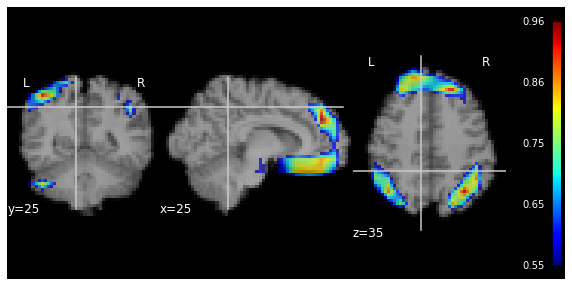

In [5]:
fig, axes = plt.subplots(figsize=(10,5))
roi_img = nib.Nifti1Image(np.clip(mean_mask, a_min=0, a_max=1), affine=np.eye(4))
bim_img  = nib.Nifti1Image(np.squeeze(X[0]),affine=np.eye(4))
plotting.plot_roi(roi_img,bim_img,cut_coords=(25,25,35), axes=axes,colorbar=True,cmap='jet',threshold=0.55)
plt.show()
fig.savefig('meaningful perturbation.png', bbox_inches='tight')

In [21]:
masks_pertrub.shape

(2, 180, 180, 180)

In [51]:
y[1]

1

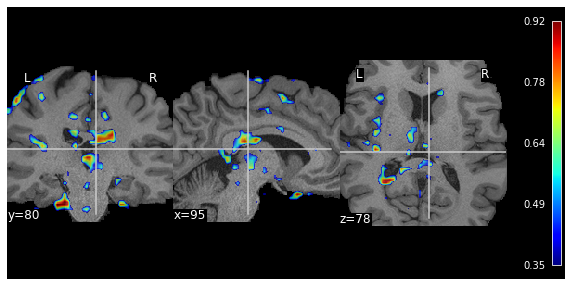

In [52]:
fig, axes = plt.subplots(figsize=(10,5))
roi_img = nib.Nifti1Image(np.clip(masks_pertrub[1], a_min=0, a_max=1), affine=np.eye(4))
bim_img  = nib.Nifti1Image(np.squeeze(X[1]),affine=np.eye(4))
plotting.plot_roi(roi_img,bim_img, axes=axes,colorbar=True,cmap='jet',threshold=0.35)
plt.show()
# fig.savefig('meanperturb_rand_label_0_0.35.png', bbox_inches='tight')

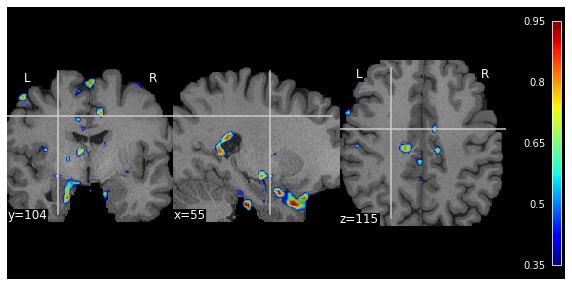

In [53]:
fig, axes = plt.subplots(figsize=(10,5))
roi_img = nib.Nifti1Image(np.clip(masks_pertrub[1], a_min=0, a_max=1), affine=np.eye(4))
bim_img  = nib.Nifti1Image(np.squeeze(X[1]),affine=np.eye(4))
plotting.plot_roi(roi_img,bim_img,(55,104,115), axes=axes,colorbar=True,cmap='jet',threshold=0.35)
plt.show()
# fig.savefig('meanperturb_rand_label_0_0.35.png', bbox_inches='tight')

In [14]:
# skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
# EPOCHS = 20
# m = 0
# cross_mask =[]
# for Mask in [man_mean_mask, woman_mean_mask, mean_mask]:
#     torch.manual_seed(82)
#     torch.cuda.manual_seed(82)
#     np.random.seed(82)
#     print('Doing {} mask'.format(m))
#     m += 1
#     cross_vall_acc_list = []
#     j = 0
#     for train_index, test_index in skf.split(X, y,):
#         print('Doing {} split'.format(j))
#         j += 1
    
#         X_train, X_test = X[train_index], X[test_index]
#         y_train, y_test = y[train_index], y[test_index]
#         train_dataset = MriData(X_train, y_train)
#         val_dataset = MriData(X_test * Mask, y_test)
#         train_loader = torch_data.DataLoader(train_dataset, batch_size=45, shuffle=True)  #45 - recommended value for batchsize
#         val_loader = torch_data.DataLoader(val_dataset, batch_size=28, shuffle=False) 
        
#         model = mri_model.MriNet(C).to(device)
#         criterion = nn.NLLLoss( )
#         optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
#         scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 15], gamma=0.1)
    
#         train(EPOCHS, model, criterion, optimizer, train_loader, val_loader,device,scheduler=scheduler, save=False, verbose=False) 
#         cross_vall_acc_list.append(get_accuracy(model, val_loader, device))
#     cross_mask.append(cross_vall_acc_list)
# cv_acc = np.array(cross_mask)
# np.save(os.path.join(CHECKPOINTS_DIR, 'cv_masks'), cv_acc)

In [9]:
# print('Mean cross-validation accuracy for man mask (10-folds):', np.mean(cv_acc[0]))
# print('Std cross-validation accuracy for man mask (10-folds):', np.std(cv_acc[0], ddof=1))
# print()
# print('Mean cross-validation accuracy for woman mask (10-folds):', np.mean(cv_acc[1]))
# print('Std cross-validation accuracy for woman mask (10-folds):', np.std(cv_acc[1], ddof=1))
# print()
# print('Mean cross-validation accuracy for conj mask (10-folds):', np.mean(cv_acc[2]))
# print('Std cross-validation accuracy for conj mask (10-folds):', np.std(cv_acc[2], ddof=1))

Mean cross-validation accuracy for man mask (10-folds): 58.55131874084473
Std cross-validation accuracy for man mask (10-folds): 17.855139440353028

Mean cross-validation accuracy for woman mask (10-folds): 59.21171226501465
Std cross-validation accuracy for woman mask (10-folds): 7.450806550883195

Mean cross-validation accuracy for conj mask (10-folds): 82.4814998626709
Std cross-validation accuracy for conj mask (10-folds): 12.269369407659404


## Grad CAM

In [19]:
!cd /home/checkpoints && ls -l

total 159111040
-rw-rw-r-- 1 1030 1031     2892078 Oct 22 00:04 10_epoch_model_adam-4_sch
-rw-rw-r-- 1 1030 1031     1245699 Oct 22 18:02 10_epoch_model_MriNetGrad
-rw-rw-r-- 1 1030 1031     2892030 Oct 22 14:49 10_epoch_model_NetGrad
-rw-rw-r-- 1 1030 1031     1245703 Oct 22 23:57 10_epoch_model_NetGradRandomiz
-rw-rw-r-- 1 1030 1031     2892078 Oct 22 00:36 20_epoch_model_adam-4_sch
-rw-rw-r-- 1 1030 1031     1245699 Oct 22 18:36 20_epoch_model_MriNetGrad
-rw-rw-r-- 1 1030 1031     2892030 Oct 22 15:21 20_epoch_model_NetGrad
-rw-rw-r-- 1 1030 1031     1245703 Oct 23 00:29 20_epoch_model_NetGradRandomiz
-rw-rw-r-- 1 1030 1031     2892078 Oct 22 01:08 30_epoch_model_adam-4_sch
-rw-rw-r-- 1 1030 1031     1245699 Oct 22 19:10 30_epoch_model_MriNetGrad
-rw-rw-r-- 1 1030 1031     2892030 Oct 22 15:54 30_epoch_model_NetGrad
-rw-rw-r-- 1 1030 1031     1245703 Oct 23 01:01 30_epoch_model_NetGradRandomiz
-rw-rw-r-- 1 1030 1031     2892078 Oct 22 01:40 40_epoch_model_adam-4_sch
-rw-rw-r-- 1 103

In [15]:

from tqdm import tqdm

In [12]:
isTrain = True

In [16]:
if isTrain:
    mask = []
    model = model.to(device) 
    model.load_state_dict(torch.load(os.path.join(CHECKPOINTS_DIR, 'best_acc_model_MriNetGrad'), map_location=device))#change path
    model.eval()
    loader = torch_data.DataLoader(dataset,
                                          shuffle=False,
                                          batch_size=128)
    i = 0
    for data,_ in tqdm(loader):
#         masks_grad = grad_cam.get_masks(model.module, data, device, mask_type='grad_cam', size=hcp_dataset[0][0].shape[1:])
        masks_grad = grad_cam.get_masks(model.module, data, device, mask_type='grad_cam', size=dataset[0][0].shape[1:])
        np.save(os.path.join(CHECKPOINTS_DIR,'masks_grad_cam_{}'.format(i)), masks_grad)
#         mask.append(masks_grad)
        i +=1

100%|██████████| 5/5 [03:42<00:00, 44.59s/it] 


In [17]:
mask = []
for i in range(0,5):
    mask.append(np.load(os.path.join(CHECKPOINTS_DIR,'masks_grad_cam_{}.npy'.format(i))))
    print(mask[i].shape)
part = np.concatenate(mask,axis=0)

(128, 180, 180, 180)
(128, 180, 180, 180)
(128, 180, 180, 180)
(128, 180, 180, 180)
(5, 180, 180, 180)


In [22]:
lab = y==1
len(lab)

517

In [23]:
mean = part[lab].mean(axis=0)
print(mean.shape)
np.save(os.path.join(CHECKPOINTS_DIR,'grad_cam_mean_labels_1'), mean)

(180, 180, 180)


In [24]:
nib.save(nib.Nifti1Image(mean, affine = np.eye(4)), os.path.join(CHECKPOINTS_DIR,'grad_cam_mean_labels_1'))

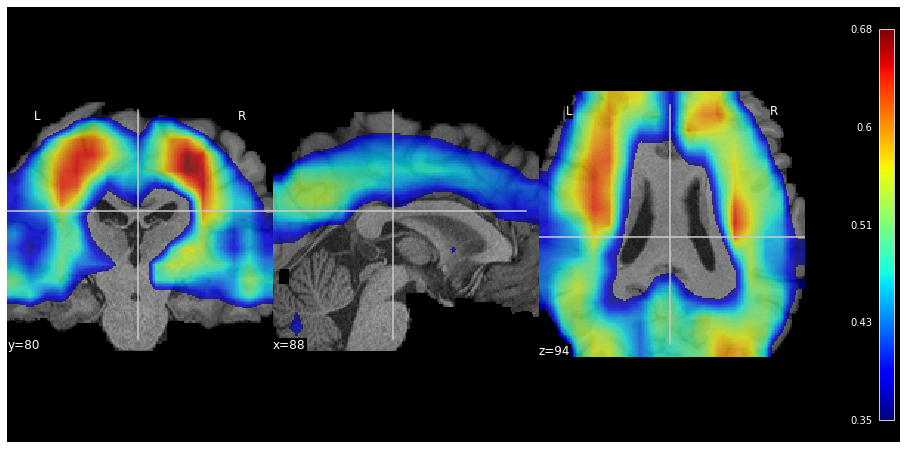

In [25]:
fig, axes = plt.subplots(figsize=(16,8))
roi_img = nib.Nifti1Image(mean,affine=np.eye(4))
bim_img  = nib.Nifti1Image(np.squeeze(dataset[1][0].numpy()),affine=np.eye(4))
plotting.plot_roi(roi_img,bim_img, axes=axes,colorbar=True,cmap='jet',threshold=0.35)
plt.show()

In [13]:
if isTrain:
    model = model.to(device)
    model.load_state_dict(torch.load(os.path.join(CHECKPOINTS_DIR, 'best_acc_model_MriNetGrad'), map_location=device))#change path
    model.eval()
    loader = torch_data.DataLoader(dataset, batch_size=1, shuffle=False)
    masks_grad = grad_cam.get_masks(model.module, loader, device, mask_type='grad_cam')
    np.save(os.path.join(CHECKPOINTS_DIR,'masks_grad_cam_part_1_gold'), masks_grad)
else:
    masks_grad1 = np.load(os.path.join(CHECKPOINTS_DIR, 'masks_grad_cam_part_1_gold.npy'))
#     masks_grad1 = np.load(os.path.join(CHECKPOINTS_DIR, 'masks_grad_cam_for_onlylabel_1.npy'))

TypeError: list indices must be integers or slices, not tuple

In [ ]:
if isTrain:
    model = model.to(device)
    model.load_state_dict(torch.load(os.path.join(CHECKPOINTS_DIR, 'best_acc_model_MriNetGrad'), map_location=device))#change path
    model.eval()
    loader = torch_data.DataLoader(dataset, batch_size=1, shuffle=False)
    masks_grad = grad_cam.get_masks(model.module, loader, device, mask_type='grad_cam')
    np.save(os.path.join(CHECKPOINTS_DIR,'masks_grad_cam_part2_right_label'), masks_grad)
else:
    masks_grad2 = np.load(os.path.join(CHECKPOINTS_DIR, 'masks_grad_cam_part2_right_label.npy'))

In [34]:
roi_img = nib.Nifti1Image(masks_grad.mean(axis=0),affine=np.eye(4))


In [19]:
def plot_central_cuts(img, title="", t=None):
    """
    param image: tensor or np array of shape (CxDxHxW) if t is None
    param image: tensor or np array of shape (TxCxDxHxW) if t is not None
    """
    if t is not None:
        img = img[t]
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(3 * 6, 6))
    fig.suptitle(title)
    axes[0].imshow(img[0, img.shape[1] // 2, :, :])
    axes[1].imshow(img[0, :, img.shape[2] // 2, :])
    axes[2].imshow(img[0, :, :, img.shape[3] // 2])
    plt.show()

In [29]:
len(masks_grad1[loader.dataset.y==0])

307

In [26]:
mean = masks_grad1[loader.dataset.y==0].mean(axis=0)

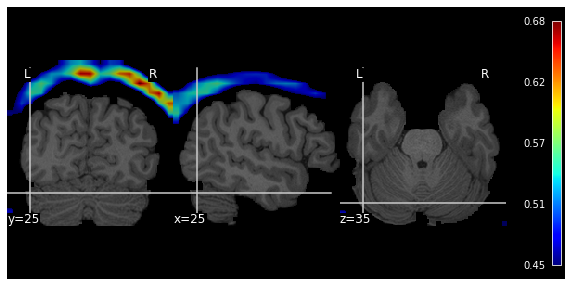

In [28]:
fig, axes = plt.subplots(figsize=(10,5))
roi_img = nib.Nifti1Image(mean,affine=np.eye(4))
bim_img  = nib.Nifti1Image(np.squeeze(X[0]),affine=np.eye(4))
plotting.plot_roi(roi_img,bim_img,cut_coords=(25,25,35), axes=axes,colorbar=True,cmap='jet',threshold=0.45)
plt.show()
fig.savefig("grad_cam_for_label_12_label_0_mean.png", bbox_inches='tight')

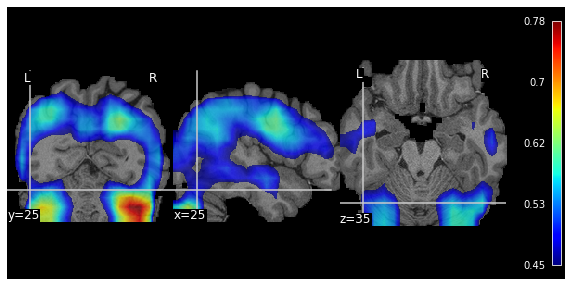

In [21]:
fig, axes = plt.subplots(figsize=(10,5))
roi_img = nib.Nifti1Image(mean,affine=np.eye(4))
bim_img  = nib.Nifti1Image(np.squeeze(X[1]),affine=np.eye(4))
plotting.plot_roi(roi_img,bim_img,cut_coords=(25,25,35), axes=axes,colorbar=True,cmap='jet',threshold=0.45)
plt.show()
fig.savefig("grad_cam_for_only1label_label_1_mean.png", bbox_inches='tight')

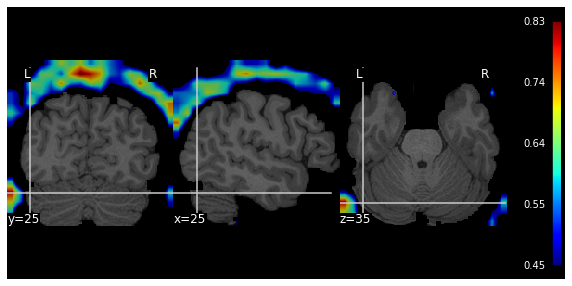

In [28]:
fig, axes = plt.subplots(figsize=(10,5))
roi_img = nib.Nifti1Image(masks_grad[0],affine=np.eye(4))
bim_img  = nib.Nifti1Image(np.squeeze(X[0]),affine=np.eye(4))
plotting.plot_roi(roi_img,bim_img,cut_coords=(25,25,35), axes=axes,colorbar=True,cmap='jet',threshold=0.45)
plt.show()
fig.savefig("grad_cam_0_label_0.45.png", bbox_inches='tight')

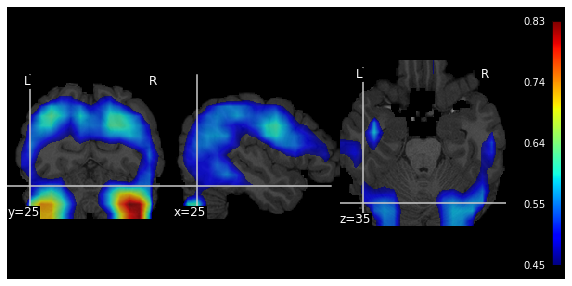

In [15]:
fig, axes = plt.subplots(figsize=(10,5))
roi_img = nib.Nifti1Image(masks_grad[y==0].mean(axis=0),affine=np.eye(4))
bim_img  = nib.Nifti1Image(np.squeeze(X[3]),affine=np.eye(4))
plotting.plot_roi(roi_img,bim_img,cut_coords=(25,25,35), axes=axes,colorbar=True,cmap='jet',threshold=0.45)
plt.show()
fig.savefig("grad_cam.png", bbox_inches='tight')

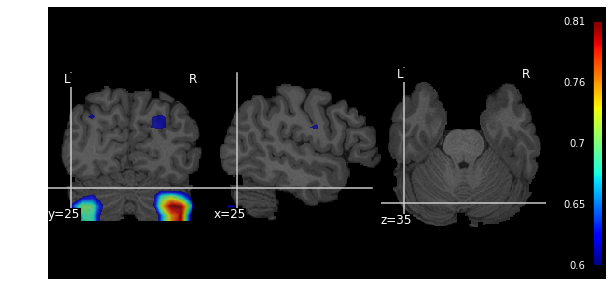

In [90]:
fig, axes = plt.subplots(figsize=(10,5))
roi_img = nib.Nifti1Image(masks_grad.mean(axis=0),affine=np.eye(4))
bim_img  = nib.Nifti1Image(np.squeeze(X[0]),affine=np.eye(4))
plotting.plot_roi(roi_img,bim_img,cut_coords=(25,25,35), axes=axes,colorbar=True,cmap='jet',threshold=0.6)
plt.show()
fig.savefig("grad_cam.png", bbox_inches='tight')

## Guided Back-propagation

In [26]:
isTrain = False

In [27]:
if isTrain:
    masks_gb = grad_cam.get_masks(model.module, loader, device, mask_type='guided_backprop')
    np.save(os.path.join(CHECKPOINTS_DIR,'masks_gb'), masks_gb)
else:
    masks_gb =  np.load(os.path.join(CHECKPOINTS_DIR, 'masks_gb.npy'))

In [28]:
y

array([0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

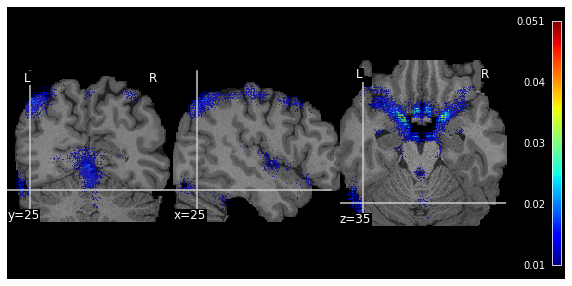

In [29]:
fig, axes = plt.subplots(figsize=(10,5))
roi_img = nib.Nifti1Image(masks_gb[y==1].mean(axis=0),affine=np.eye(4))
bim_img  = nib.Nifti1Image(np.squeeze(X[1]),affine=np.eye(4))
plotting.plot_roi(roi_img,bim_img,cut_coords=(25,25,35), axes=axes,colorbar=True,cmap='jet',threshold=0.01)
plt.show()
# fig.savefig("guided backpropagation.png", bbox_inches='tight')

## DICE

In [ ]:
def dice(x, y):
    overlap = x == y
    return 2 * overlap.sum() / (x.size + y.size)

In [ ]:
gm = masks_grad.mean(axis=0)
gbm = masks_gb.mean(axis=0)

In [4]:
g_b = dice(gm > 0.6, gbm > 0.01)
print('Dice between Grad Cam mask and Guided Back-propagation', g_b)

NameError: name 'gm' is not defined